# LSTM

In [58]:
# imports
import time
import os
import optuna
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, balanced_accuracy_score, precision_score, f1_score, recall_score, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from nltk.corpus import stopwords
import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data loading and exploration

In [62]:
ag_news_train_df = pd.read_csv('data/ag_news_train.csv')
ag_news_test_df = pd.read_csv('data/ag_news_test.csv')
amazon_reviews_df = pd.read_csv('data/cleaned_amazon_reviews.csv')

In [63]:
ag_news_train_df.shape

(120000, 3)

In [64]:
ag_news_test_df.shape

(7600, 3)

In [65]:
ag_news_train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [66]:
amazon_reviews_df.shape

(17340, 4)

In [67]:
amazon_reviews_df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [68]:
amazon_reviews_df.isna().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

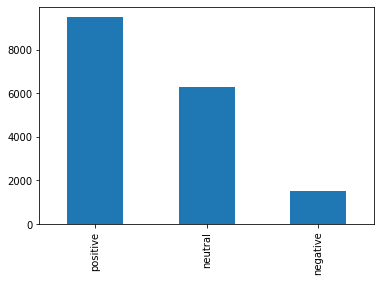

In [69]:
amazon_reviews_df.sentiments.value_counts().plot(kind='bar')

Unbalanced target

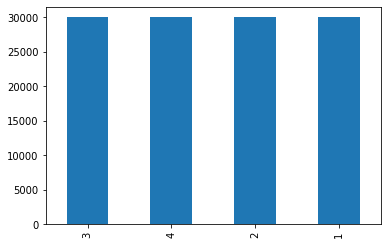

In [70]:
ag_news_train_df['Class Index'].value_counts().plot(kind='bar')

Balanced target

#### Distribution of review lengths

(array([1.4993e+04, 1.8380e+03, 3.4300e+02, 8.3000e+01, 5.0000e+01,
        1.2000e+01, 9.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  0. ,  57.1, 114.2, 171.3, 228.4, 285.5, 342.6, 399.7, 456.8,
        513.9, 571. ]),
 <a list of 10 Patch objects>)

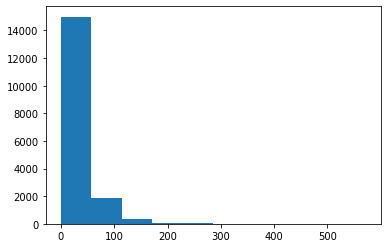

In [71]:
plt.hist(amazon_reviews_df.cleaned_review_length)

#### Distribution of the news article lengths

(array([4.8100e+03, 6.7638e+04, 4.1664e+04, 4.2770e+03, 1.0700e+03,
        2.9800e+02, 9.3000e+01, 9.0000e+01, 2.9000e+01, 3.1000e+01]),
 array([  6. , 103.9, 201.8, 299.7, 397.6, 495.5, 593.4, 691.3, 789.2,
        887.1, 985. ]),
 <a list of 10 Patch objects>)

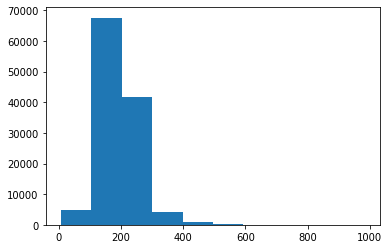

In [72]:
plt.hist(ag_news_train_df.Description.str.len())

In [73]:
ag_news_train_df.isna().any()

Class Index    False
Title          False
Description    False
dtype: bool

#### Removing NaNs

In [74]:
amazon_reviews_df.dropna(inplace=True)

## 2. Train/Val/Test split

In [75]:
X_amazon_reviews = amazon_reviews_df.drop(columns=['sentiments'])
y_amazon_reviews = amazon_reviews_df['sentiments']

In [76]:
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_amazon_reviews,
                                                                                   y_amazon_reviews,
                                                                                   random_state=42,
                                                                                   test_size=0.2)

In [77]:
X_train_reviews, X_valid_reviews, y_train_reviews, y_valid_reviews = train_test_split(X_train_reviews,
                                                                                     y_train_reviews,
                                                                                     random_state=42,
                                                                                     test_size = 0.25)

### Splitting ag news into X and y's

Merging Title and Description into one field, "Text"

In [78]:
ag_news_train_df['Text'] = ag_news_train_df[['Title', 'Description']].agg(' '.join,axis=1)
ag_news_test_df['Text'] = ag_news_test_df[['Title', 'Description']].agg(' '.join,axis=1)

In [79]:
ag_news_train_df['Text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Text, Length: 120000, dtype: object

In [80]:
X_train_news = ag_news_train_df['Text']
y_train_news = ag_news_train_df['Class Index']

X_test_news = ag_news_test_df['Text']
y_test_news = ag_news_test_df['Class Index']

In [81]:
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news,
                                                                          y_train_news,
                                                                          random_state=42,
                                                                          test_size = 0.25)

In [82]:
# split the data sets accordignly, so we can perform hyperparameter tuning somewhat successfully

np.random.seed(42)
reviews_train_idx = np.random.choice(y_train_reviews.shape[0], 
                                     replace=False, size=y_train_reviews.shape[0]//2)
news_train_idx = np.random.choice(y_train_news.shape[0], 
                                     replace=False, size=y_train_news.shape[0]//8)

X_train_reviews_half = X_train_reviews.iloc[reviews_train_idx,:]
y_train_reviews_half = y_train_reviews.iloc[reviews_train_idx]
X_train_news_eight = X_train_news.iloc[news_train_idx]
y_train_news_eight = y_train_news.iloc[news_train_idx]

## 3. Model development - LSTM

### 3.1. Reviews data set

In [ ]:
# setting the vocabulary and sentence length
voc_size = 5000
sent_length = 40
embedding_vector_features = 40

In [ ]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

In [ ]:
X_train.head()

,cleaned_review,cleaned_review_length,review_score
11652,i do love this product but bought it think had...,19,4.0
7240,this mouse works very well and has very long b...,16,5.0
16483,just like described very pleased we also had a...,45,5.0
13353,our year old son asked for this headset for hi...,44,5.0
6024,nice looking mouse beautiful colors and comfor...,69,5.0


In [99]:
def preprocessing_reviews(X, y, sent_length):
    X.drop(['cleaned_review_length', 'review_score'], axis=1, inplace=True)
    corpus = X['cleaned_review'].values.tolist()
    onehot_repr = [one_hot(words, voc_size) for words in corpus] 
    embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sent_length)
        
    y = pd.get_dummies(y)
    
    X = np.array(embedded_docs)
    y = np.array(y)
    
    return (X, y)

In [ ]:
X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

#### 3.1.1. Reviews, LSTM model 1. - base

In [ ]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 256,703
Trainable params: 256,703
Non-trainable params: 0
_________________________________________________________________
None


The results show that the model is overfitting the training data and not generalizing well to the validation data. This can be seen from the increasing difference between training accuracy and validation accuracy as the number of epochs increases.

The training accuracy increases up to 95.6% while the validation accuracy only reaches 82.15%. This suggests that the model is memorizing the training data rather than learning the underlying patterns that can be generalized to the validation set.

The loss is also decreasing on the training set, but increasing on the validation set. This further supports the overfitting issue.


To address the overfitting issue, we will try using regularization techniques like dropout, or simplifying the model architecture.

In [ ]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

109/109 [==============================] - 2s 15ms/step


In [ ]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

reviews_m1_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m1_results['train_time'] = train_time
reviews_m1_results['test_time'] = test_time
reviews_m1_results = pd.DataFrame.from_dict(reviews_m1_results)
reviews_m1_results.to_csv('results/lstm/reviews/model_1.csv')
pickle.dump(model, open('models/lstm/reviews/model_1.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-23 14:18:52           64
config.json                                    2023-02-23 14:18:52         2204
variables.h5                                   2023-02-23 14:18:53      3107104


In [ ]:
reviews_m1_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.607143,0.678799,0.897140,0.791522,0.727694,0.792227,32.089595,2.254562
recall,0.161905,0.851763,0.856168,0.791522,0.623279,0.791522,32.089595,2.254562
f1-score,0.255639,0.755508,0.876175,0.791522,0.629107,0.776388,32.089595,2.254562
support,315.000000,1248.000000,1905.000000,0.791522,3468.000000,3468.000000,32.089595,2.254562


The test accuracy is 0.827 which is very similar to the validation results, therefore we will try to add dropout layers, or simplify the model architecture.

We are using accuracy at the moment, we will later on focus on more metrics, and see in greated details how to best optimize the model.

#### 3.1.2. Reviews, LSTM model 2. - base with dropout

In [ ]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 40, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 256,703
Trainable params: 256,703
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

109/109 [==============================] - 2s 14ms/step


In [ ]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
# y_test = np.argmax(y_test, axis = 1)

reviews_m2_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m2_results['train_time'] = train_time
reviews_m2_results['test_time'] = test_time
reviews_m2_results = pd.DataFrame.from_dict(reviews_m2_results)
reviews_m2_results.to_csv('results/lstm/reviews/model_2.csv')
pickle.dump(model, open('models/lstm/reviews/model_2.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......precision
.........vars
............0
............1
......recall
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-23 14:19:38           64
config.json                                    202

In [ ]:
reviews_m2_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.652174,0.675316,0.886863,0.788927,0.738118,0.789419,24.234262,2.115632
recall,0.047619,0.854968,0.868241,0.788927,0.590276,0.788927,24.234262,2.115632
f1-score,0.088757,0.754597,0.877454,0.788927,0.573603,0.761605,24.234262,2.115632
support,315.000000,1248.000000,1905.000000,0.788927,3468.000000,3468.000000,24.234262,2.115632


After adding two dropout layers with the probability of 0.3, we get an accuracy of 0.828 which isn't an improvement really. We will now try to change the model architecture, and see what we can get.

We will change the voc_size and the sent_length to see if that can make the results better.

#### 3.1.3. Reviews, LSTM model 3. - dropout and voc and sent length changed

In [ ]:
# setting the vocabulary and sentence length
voc_size = 10000
sent_length = 100
embedding_vector_features = 60

In [ ]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

In [ ]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 60)           600000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              128800    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 3)                 603       
                                                                 
Total params: 729,403
Trainable params: 729,403
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

109/109 [==============================] - 8s 68ms/step


In [ ]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
# y_test = np.argmax(y_test, axis = 1)

reviews_m3_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m3_results['train_time'] = train_time
reviews_m3_results['test_time'] = test_time
reviews_m3_results = pd.DataFrame.from_dict(reviews_m3_results)
reviews_m3_results.to_csv('results/lstm/reviews/model_3.csv')
pickle.dump(model, open('models/lstm/reviews/model_3.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                             

In [ ]:
reviews_m3_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.673077,0.669109,0.906074,0.790657,0.749420,0.799636,87.403893,8.382079
recall,0.111111,0.878205,0.845669,0.790657,0.611662,0.790657,87.403893,8.382079
f1-score,0.190736,0.759529,0.874830,0.790657,0.608365,0.771201,87.403893,8.382079
support,315.000000,1248.000000,1905.000000,0.790657,3468.000000,3468.000000,87.403893,8.382079


The best result is 84 % accuracy, which is an improvement, it mostly happened because we increased the size of the features, and the sent length, and the voc size, so it managed to capture more information. Of, course it does train longer than but that is the trade off we must accept.

#### 3.1.4. Reviews, Hyperparameter tuning

In [ ]:
X_train = X_train_reviews_half.copy()
y_train = y_train_reviews_half.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

In [ ]:
def create_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=hp.Int('voc_size', 5000, 20000, step=2500),
        output_dim=hp.Int('embedding_size', 32, 128, 32),
        input_length = 100))    
    model.add(Bidirectional(LSTM(units=hp.Int('LSTM_units', 32, 128, 32))))
    model.add(Dense(units=hp.Int('dense_units', 10, 50, 10), activation=hp.Choice('dense_activation', values=['relu', 'sigmoid', 'tanh'])))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss=CategoricalCrossentropy(),
        metrics=[Accuracy()]
    )
    return model

In [ ]:
tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='tuning',
    project_name='movie_review_sentiment_analysis'
)

INFO:tensorflow:Reloading Tuner from tuning\movie_review_sentiment_analysis\tuner0.json


INFO:tensorflow:Reloading Tuner from tuning\movie_review_sentiment_analysis\tuner0.json


In [ ]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hyperparameters)

In [ ]:
best_hyperparameters.values

{'voc_size': 7500,
 'embedding_size': 64,
 'sent_length': 90,
 'LSTM_units': 64,
 'dense_units': 50,
 'dense_activation': 'relu',
 'learning_rate': 0.01}

In [ ]:
# fitting the best model

In [ ]:
# setting the vocabulary and sentence length
voc_size = 7500
sent_length = 90
embedding_vector_features = 64

In [ ]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

In [ ]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.01), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 90, 64)            480000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 50)                6450      
                                                                 
 dense_4 (Dense)             (None, 3)                 153       
                                                                 
Total params: 552,651
Trainable params: 552,651
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

109/109 [==============================] - 4s 28ms/step


In [ ]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

reviews_m4_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m4_results['train_time'] = train_time
reviews_m4_results['test_time'] = test_time
reviews_m4_results = pd.DataFrame.from_dict(reviews_m4_results)
reviews_m4_results.to_csv('results/lstm/reviews/model_4.csv')
pickle.dump(model, open('models/lstm/reviews/model_4.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........3
.........4
.........5
.........6
...

In [ ]:
reviews_m4_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.633333,0.706897,0.904891,0.8094,0.748374,0.808975,39.3978,4.347106
recall,0.241270,0.854167,0.874016,0.8094,0.656484,0.809400,39.3978,4.347106
f1-score,0.349425,0.773585,0.889186,0.8094,0.670732,0.798559,39.3978,4.347106
support,315.000000,1248.000000,1905.000000,0.8094,3468.000000,3468.000000,39.3978,4.347106


#### 3.1.4. Reviews, augmented data set

In [105]:
X_train = pd.read_csv("data/X_train_reviews_augmented.csv")
y_train = pd.read_csv("data/y_train_reviews_augmented.csv")
y_train = y_train['sentiments']

In [106]:
# setting the vocabulary and sentence length
voc_size = 7500
sent_length = 90
embedding_vector_features = 64

In [107]:
X_train = X_train.copy()
y_train = y_train.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()

X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

AttributeError: ignored

In [ ]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 60)           600000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              128800    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 3)                 603       
                                                                 
Total params: 729,403
Trainable params: 729,403
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

109/109 [==============================] - 8s 68ms/step


In [ ]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
# y_test = np.argmax(y_test, axis = 1)

reviews_m3_results = classification_report(y_test, y_pred, output_dict=True)

reviews_m3_results['train_time'] = train_time
reviews_m3_results['test_time'] = test_time
reviews_m3_results = pd.DataFrame.from_dict(reviews_m3_results)
reviews_m3_results.to_csv('results/lstm/reviews/model_3.csv')
pickle.dump(model, open('models/lstm/reviews/model_3.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                             

### 3.1.2. Model comparison

In [ ]:
reviews_m1_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.607143,0.678799,0.897140,0.791522,0.727694,0.792227,32.089595,2.254562
recall,0.161905,0.851763,0.856168,0.791522,0.623279,0.791522,32.089595,2.254562
f1-score,0.255639,0.755508,0.876175,0.791522,0.629107,0.776388,32.089595,2.254562
support,315.000000,1248.000000,1905.000000,0.791522,3468.000000,3468.000000,32.089595,2.254562


In [ ]:
reviews_m2_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.652174,0.675316,0.886863,0.788927,0.738118,0.789419,24.234262,2.115632
recall,0.047619,0.854968,0.868241,0.788927,0.590276,0.788927,24.234262,2.115632
f1-score,0.088757,0.754597,0.877454,0.788927,0.573603,0.761605,24.234262,2.115632
support,315.000000,1248.000000,1905.000000,0.788927,3468.000000,3468.000000,24.234262,2.115632


In [ ]:
reviews_m3_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.673077,0.669109,0.906074,0.790657,0.749420,0.799636,87.403893,8.382079
recall,0.111111,0.878205,0.845669,0.790657,0.611662,0.790657,87.403893,8.382079
f1-score,0.190736,0.759529,0.874830,0.790657,0.608365,0.771201,87.403893,8.382079
support,315.000000,1248.000000,1905.000000,0.790657,3468.000000,3468.000000,87.403893,8.382079


In [ ]:
reviews_m4_results

,0,1,2,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.608163,0.789260,0.889168,0.83391,0.762197,0.827691,51.895286,5.975963
recall,0.473016,0.777244,0.930709,0.83391,0.726989,0.833910,51.895286,5.975963
f1-score,0.532143,0.783205,0.909464,0.83391,0.741604,0.829756,51.895286,5.975963
support,315.000000,1248.000000,1905.000000,0.83391,3468.000000,3468.000000,51.895286,5.975963


Conclusion

### 3.2. News data set

In [89]:
### helper functions

# Tokenize the sentence into words
lemmatizer = WordNetLemmatizer()

def lemmetize_it(sentence):
    words = nltk.word_tokenize(sentence)
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    lemmas_str = ' '.join(lemmas)
    return lemmas_str

def clean_news_data(X):    
    X = X.apply(lambda x: " ".join(x.lower() for x in x.split()))
    X = X.str.replace('[^\w\s]','', regex=True)
    
    stop = stopwords.words('english')
    X = X.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    # Create a WordNet lemmatizer object
    lemmatizer = WordNetLemmatizer()
    
    X = X.apply(lemmetize_it)
    
    return(X)

def preprocessing_news(X, y, sent_length):
    corpus = X.values.tolist()
    onehot_repr = [one_hot(words, voc_size) for words in corpus] 
    embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sent_length)
        
    y = pd.get_dummies(y)
    
    X = np.array(embedded_docs)
    y = np.array(y)
    
    return (X, y)

In [ ]:
X_train = X_train_news.copy()
y_train = y_train_news.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()
X_valid = X_valid_news.copy()
y_valid = y_valid_news.copy()

X_train = clean_news_data(X_train)
X_valid = clean_news_data(X_valid)
X_test = clean_news_data(X_test)

### 3.2.1. News, LSTM model 1 - base

In [ ]:
# setting the vocabulary and sentence length
voc_size = 10000
sent_length = 150
embedding_vector_features = 50

In [ ]:
X_train, y_train = preprocessing_news(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_news(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_news(X_test, y_test, sent_length)

In [ ]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(4, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 50)           500000    
                                                                 
 lstm_5 (LSTM)               (None, 100)               60400     
                                                                 
 dense_6 (Dense)             (None, 4)                 404       
                                                                 
Total params: 560,804
Trainable params: 560,804
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

238/238 [==============================] - 13s 52ms/step


In [ ]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

news_m1_results = classification_report(y_test, y_pred, output_dict=True)

news_m1_results['train_time'] = train_time
news_m1_results['test_time'] = test_time
news_m1_results = pd.DataFrame.from_dict(news_m1_results)
news_m1_results.to_csv('results/lstm/news/model_1.csv')
pickle.dump(model, open('models/lstm/news/model_1.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-23 14:37:14           64
config.json                                    2023-02-23 14:37:14         2219
variables.h5                                   2023-02-23 14:37:14      6755904


In [ ]:
news_m1_results

,0,1,2,3,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.901254,0.937468,0.860847,0.882996,0.896184,0.895641,0.895641,540.047065,20.94732
recall,0.907895,0.970526,0.856316,0.850000,0.896184,0.896184,0.896184,540.047065,20.94732
f1-score,0.904562,0.953711,0.858575,0.866184,0.896184,0.895758,0.895758,540.047065,20.94732
support,1900.000000,1900.000000,1900.000000,1900.000000,0.896184,7600.000000,7600.000000,540.047065,20.94732


Based on the provided results of the LSTM model, it appears to be a good starting point for the news classification task. The training accuracy increased with each epoch, while the validation accuracy remained consistently high, suggesting that the model is generalizing well to new data. The validation loss did not increase significantly over the three epochs, indicating that the model is not overfitting. Overall, the model achieved an accuracy of 85.5% on the validation data.

The test accuracy is 86.9% which is very similar to the validation results, therefore we will try to add dropout layers, or simplify the model architecture.

#### 3.1.2. LSTM model 2. - dropout and voc and sent length changed

---



In [ ]:
# setting the vocabulary and sentence length
voc_size = 20000
sent_length = 200
embedding_vector_features = 100

In [ ]:
X_train = X_train_news.copy()
y_train = y_train_news.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()

X_train = clean_news_data(X_train)
X_test = clean_news_data(X_test)

X_train, y_train = preprocessing_news(X_train, y_train, sent_length)
X_test, y_test = preprocessing_news(X_test, y_test, sent_length)

In [ ]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(4, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 804       
                                                                 
Total params: 2,161,604
Trainable params: 2,161,604
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

238/238 [==============================] - 27s 106ms/step


In [ ]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

news_m2_results = classification_report(y_test, y_pred, output_dict=True)

news_m2_results['train_time'] = train_time
news_m2_results['test_time'] = test_time
news_m2_results = pd.DataFrame.from_dict(news_m2_results)
news_m2_results.to_csv('results/lstm/news/model_2.csv')
pickle.dump(model, open('models/lstm/news/model_2.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                             

In [ ]:
news_m2_results

,0,1,2,3,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.947698,0.942494,0.842415,0.893964,0.905132,0.906643,0.906643,1345.974194,42.282684
recall,0.877368,0.974737,0.903158,0.865263,0.905132,0.905132,0.905132,1345.974194,42.282684
f1-score,0.911178,0.958344,0.871730,0.879380,0.905132,0.905158,0.905158,1345.974194,42.282684
support,1900.000000,1900.000000,1900.000000,1900.000000,0.905132,7600.000000,7600.000000,1345.974194,42.282684


#### 3.1.3. News, Hyperparameter tuning

In [ ]:
# setting the vocabulary and sentence length
voc_size = 20000
sent_length = 200
embedding_vector_features = 50

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
X_train = X_train_news_eight.copy()
y_train = y_train_news_eight.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()
X_valid = X_valid_news.copy()
y_valid = y_valid_news.copy()

X_train = clean_news_data(X_train)
X_valid = clean_news_data(X_valid)
X_test = clean_news_data(X_test)

X_train, y_train = preprocessing_news(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_news(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_news(X_test, y_test, sent_length)

In [ ]:
def create_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=hp.Int('voc_size', 15000, 30000, step=5000),
        output_dim=hp.Int('embedding_size', 32, 160, 32),
        input_length = 200))    
    model.add(Bidirectional(LSTM(units=hp.Int('LSTM_units', 32, 128, 32))))
    model.add(Dense(units=hp.Int('dense_units', 10, 50, 10), activation=hp.Choice('dense_activation', values=['relu', 'sigmoid', 'tanh'])))
    model.add(Dense(units=4, activation='softmax'))
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss=CategoricalCrossentropy(),
        metrics=[Accuracy()]
    )
    return model

In [ ]:
tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='tuning',
    project_name='news'
)

In [ ]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 03m 57s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 30m 05s


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hyperparameters)

In [ ]:
best_hyperparameters.values

{'voc_size': 30000,
 'embedding_size': 32,
 'LSTM_units': 96,
 'dense_units': 40,
 'dense_activation': 'tanh',
 'learning_rate': 0.001}

{'voc_size': 30000,
 'embedding_size': 32,
 'LSTM_units': 96,
 'dense_units': 40,
 'dense_activation': 'tanh',
 'learning_rate': 0.001}

#### 3.1.4. News, Fitting the best hyperparameters

In [ ]:
# setting the vocabulary and sentence length
voc_size = 30000
sent_length = 200
embedding_vector_features = 32

In [ ]:
X_train = X_train_news.copy()
y_train = y_train_news.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()

X_train = clean_news_data(X_train)
X_test = clean_news_data(X_test)

X_train, y_train = preprocessing_news(X_train, y_train, sent_length)
X_test, y_test = preprocessing_news(X_test, y_test, sent_length)

In [ ]:
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(96)))
model.add(Dense(40, activation='tanh'))
model.add(Dense(4, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.01), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 50)           1000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 192)              112896    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 40)                7720      
                                                                 
 dense_5 (Dense)             (None, 4)                 164       
                                                                 
Total params: 1,120,780
Trainable params: 1,120,780
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# training and predicting

start=time.time()
model.fit(X_train, y_train)
end=time.time()

train_time = end - start

start=time.time()
y_pred = model.predict(X_test)
end=time.time()

test_time = end - start

238/238 [==============================] - 2s 6ms/step


In [ ]:
# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

news_m3_results = classification_report(y_test, y_pred, output_dict=True)

news_m3_results['train_time'] = train_time
news_m3_results['test_time'] = test_time
news_m3_results = pd.DataFrame.from_dict(news_m3_results)
news_m3_results.to_csv('results/lstm/news/model_3.csv')
pickle.dump(model, open('models/lstm/news/model_3.sav', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......embedding
.........vars
............0
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........3
.........4
.........5
.........6
...

In [ ]:
news_m3_results

,0,1,2,3,accuracy,macro avg,weighted avg,train_time,test_time
precision,0.940081,0.931244,0.871795,0.813315,0.886184,0.889109,0.889109,96.203267,3.304089
recall,0.850526,0.969474,0.805263,0.919474,0.886184,0.886184,0.886184,96.203267,3.304089
f1-score,0.893064,0.949974,0.837209,0.863142,0.886184,0.885848,0.885848,96.203267,3.304089
support,1900.000000,1900.000000,1900.000000,1900.000000,0.886184,7600.000000,7600.000000,96.203267,3.304089


In [ ]:
# best result is 87 % accuracy without hyperparameter tuning